In [9]:
pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 73.5 MB/s eta 0:00:00 0:00:0136m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.8/514.8 kB 9.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 8.9 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 43.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 54.0 MB/s eta 0:00:00 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install torch --index-url https://download.pytorch.org/whl/cpu

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
Looking in links: /usr/share/pip-wheels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.9/175.9 MB 11.3 MB/s eta 0:00:000:00:010:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install wordcloud

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 6.8 MB/s eta 0:00:00 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


# Employee Sentiment Analysis Project

This notebook presents a comprehensive analysis of employee email messages to assess sentiment and engagement.  
The steps include data loading, sentiment labeling, exploratory data analysis (EDA), employee scoring, ranking, 
flight risk identification, and predictive modeling.

In [50]:
# Importing all the required libraries
import pandas as pd
import numpy as np
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

#### Task 1: Sentiment Labeling

- Loading the dataset and parsing dates.
- Using a pretrained transformer model (DistilBERT fine-tuned on SST-2) to label each message as Positive, Negative, or Neutral.
- Truncating messages to 512 tokens for performance.
- Assigning sentiment labels based on model confidence threshold (0.6).

In [2]:
# Loading the dataset and parsing 'date' column as datetime type for time series operations
df = pd.read_csv('test.csv', parse_dates=['date'])

# Initializing the Hugging Face sentiment pipeline with distilbert fine-tuned on SST-2
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to analyze sentiment of each message using the pipeline
def analyze_sentiment(text, threshold=0.6):
    
    # To handle the missing or empty text by labeling as Neutral
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "Neutral"

    # Limit input for performance and model constraints
    result = sentiment_pipeline(text[:512])[0]
    label = result['label']
    score = result['score']

    # Assigning sentiment label based on confidence threshold
    if label == 'POSITIVE' and score >= threshold:
        return "Positive"
    elif label == 'NEGATIVE' and score >= threshold:
        return "Negative"
    else:
        return "Neutral"

# Applying sentiment labeling to the 'body' column
df['sentiment'] = df['body'].apply(analyze_sentiment)

Device set to use cpu


- Successfully labeled each employee message into Positive, Negative, or Neutral using a Hugging Face DistilBERT sentiment analysis model.
- The model provides a reproducible and automated approach to sentiment classification, enabling downstream analysis.

#### Task 2: Exploratory Data Analysis (EDA)

- Examining data structure and checking for missing values.
- Visualizing sentiment distribution as percentages.
- Exploring message length statistics and distributions by sentiment.
- Analyzing monthly sentiment trends.
- Identifying top active employees by message volume.
- Generating word clouds for positive and negative messages.

In [3]:
# Overall structure and missing values
print("\nDataset Structure:\n")
df.info()

print("\nCount of each sentiment:\n", df['sentiment'].value_counts())
print("\nMissing values per column:\n", df.isnull().sum())


Dataset Structure:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Subject    2191 non-null   object        
 1   body       2191 non-null   object        
 2   date       2191 non-null   datetime64[ns]
 3   from       2191 non-null   object        
 4   sentiment  2191 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 85.7+ KB

Count of each sentiment:
 sentiment
Negative    1177
Positive     924
Neutral       90
Name: count, dtype: int64

Missing values per column:
 Subject      0
body         0
date         0
from         0
sentiment    0
dtype: int64


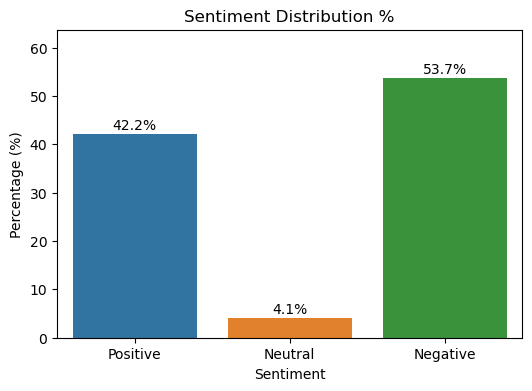

In [4]:
# Plotting sentiment distribution to visualize balance between classes
# Calculating sentiment as percentages
sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100
sentiment_percentages = sentiment_counts.reset_index()
sentiment_percentages.columns = ['sentiment', 'percentage']

# Ensuring DataFrame is ordered to match barplot order
order = ['Positive', 'Neutral', 'Negative']
sentiment_percentages = sentiment_percentages.set_index('sentiment').loc[order].reset_index()

# Plotting percentage barplot
plt.figure(figsize=(6,4))
sns.barplot(x='sentiment', y='percentage', data=sentiment_percentages, order=order)
plt.title('Sentiment Distribution %')
plt.ylabel('Percentage (%)')
plt.xlabel('Sentiment')

# To add percentage labels on top of bars
for index, row in sentiment_percentages.iterrows():
    plt.text(index, row['percentage'] + 1, f"{row['percentage']:.1f}%", ha='center')

plt.ylim(0, sentiment_percentages['percentage'].max() + 10)
plt.show()

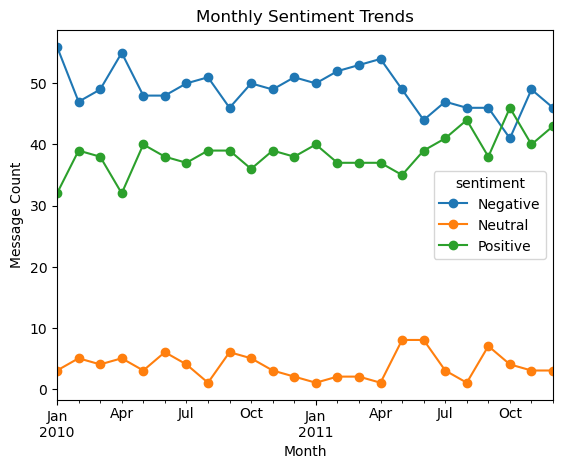

In [5]:
# To analyze sentiment trends over time (months)
df['month'] = df['date'].dt.to_period('M') # Extracting year-month period for grouping
monthly_sentiment = df.groupby(['month', 'sentiment']).size().unstack().fillna(0) # To count no. of messages per sentiment per month

monthly_sentiment.plot(kind='line', marker='o')
plt.title('Monthly Sentiment Trends')
plt.xlabel('Month')
plt.ylabel('Message Count')
plt.show()

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


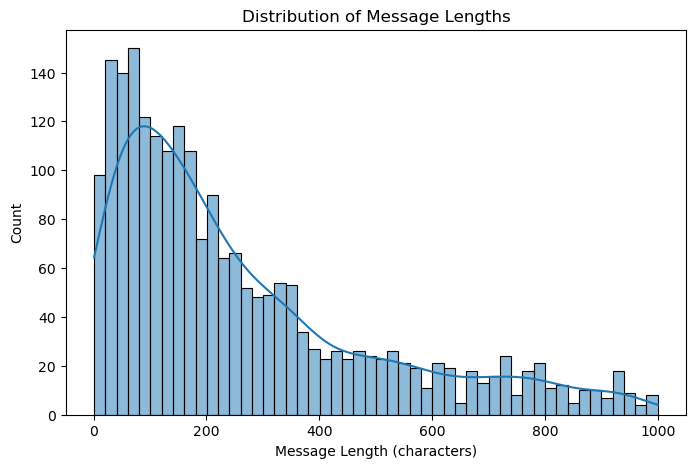

In [6]:
# Message length analysis
df['message_length'] = df['body'].apply(lambda x: len(str(x))) # Calculating message length in characters

# Plotting distribution of message lengths
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='message_length', bins=50, kde=True)
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length (characters)')
plt.show()

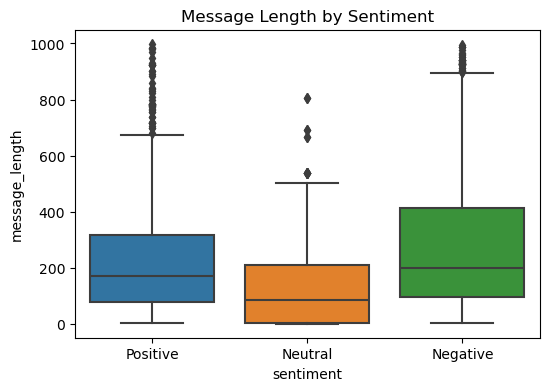

In [7]:
# Message length by sentiment to detect patterns
plt.figure(figsize=(6,4))
sns.boxplot(x='sentiment', y='message_length', data=df, order=['Positive', 'Neutral', 'Negative'])
plt.title('Message Length by Sentiment')
plt.show()

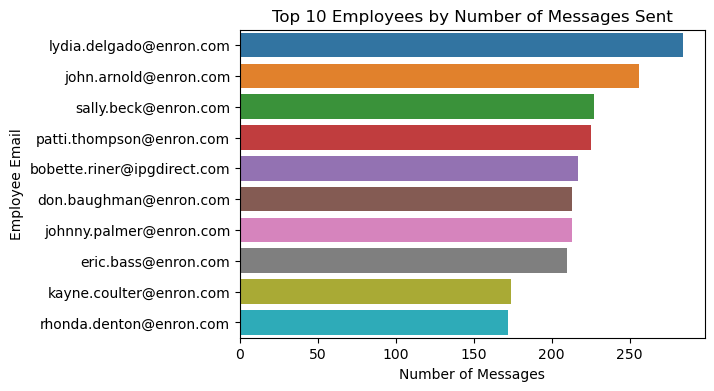

In [41]:
# Analyze no. of messages sent by each employee - top 10 most active senders
top_senders = df['from'].value_counts().head(10)

plt.figure(figsize=(6,4))
sns.barplot(y=top_senders.index, x=top_senders.values)
plt.title('Top 10 Employees by Number of Messages Sent')
plt.xlabel('Number of Messages')
plt.ylabel('Employee Email')
plt.show()

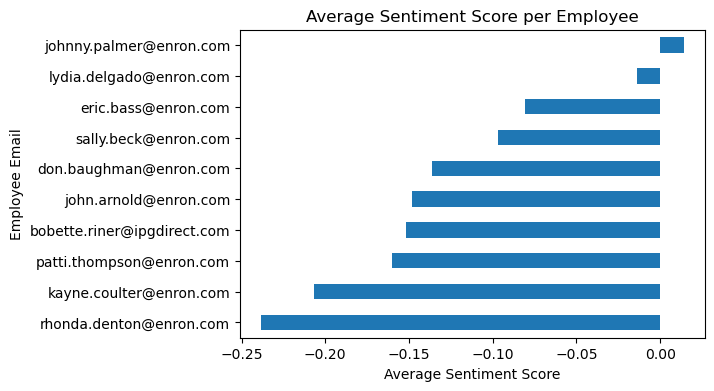

In [42]:
# Average sentiment score per employee
# Map sentiment labels to numeric scores for aggregation
sentiment_score_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['sentiment_score'] = df['sentiment'].map(sentiment_score_map)

# Calculate average sentiment score per employee and sort
avg_sentiment_employee = df.groupby('from')['sentiment_score'].mean().sort_values()

plt.figure(figsize=(6,4))
avg_sentiment_employee.plot(kind='barh')
plt.title('Average Sentiment Score per Employee')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Employee Email')
plt.show()

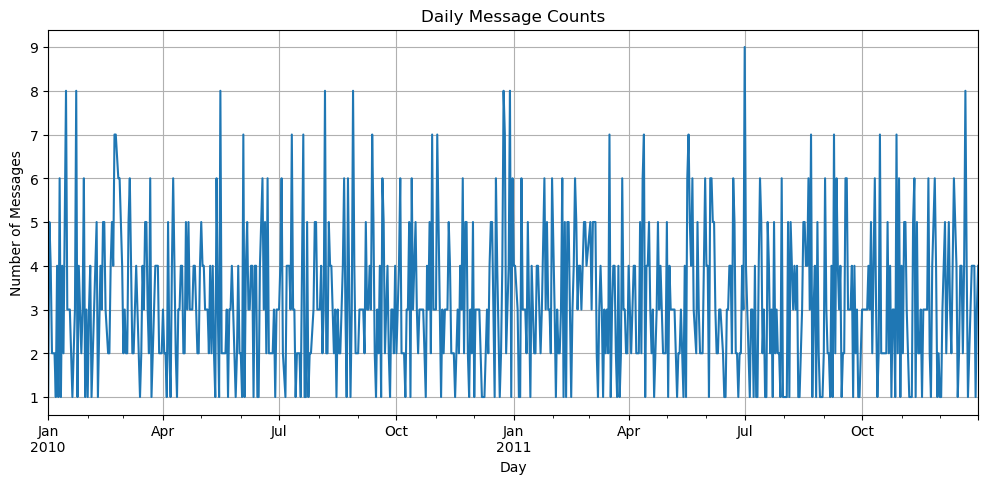

In [10]:
# Daily message count to check for temporal anomalies
df['day'] = df['date'].dt.to_period('D')
daily_counts = df.groupby('day').size()

plt.figure(figsize=(12,5))
daily_counts.plot()
plt.title('Daily Message Counts')
plt.xlabel('Day')
plt.ylabel('Number of Messages')
plt.grid(True)
plt.show()

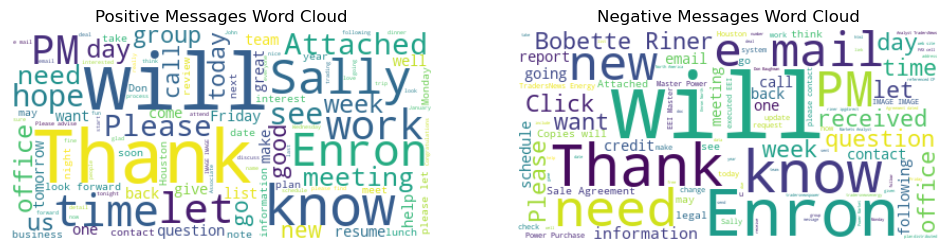

In [11]:
# Word clouds for Positive and Negative messages
positive_text = " ".join(df[df['sentiment']=='Positive']['body'].dropna())
negative_text = " ".join(df[df['sentiment']=='Negative']['body'].dropna())

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
wc_pos = WordCloud(background_color='white', max_words=100).generate(positive_text)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Messages Word Cloud')

plt.subplot(1,2,2)
wc_neg = WordCloud(background_color='white', max_words=100).generate(negative_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Messages Word Cloud')
plt.show()

Word clouds for positive and negative messages reveal common themes. Daily message counts show no unusual spikes or drops

- The dataset contains 2191 messages from two years (2010-2011) with no missing values in key columns.
- Monthly sentiment trends show negative sentiment consistently higher than positive.
- Message length vary widely, with negative messages tending to be longer and more detailed.
- Top communicators are identified, with a few employees dominating message volume, potentially impacting overall sentiment dynamics.
- Word cloud analysis highlight common positive and negative themes.

#### Task 3: Employee Score Calculation
- Aggregating sentiment scores monthly per employees.

In [26]:
# Aggregate monthly scores per employee
monthly_scores = df.groupby(['from', 'month'])['sentiment_score'].sum().reset_index().rename(columns={'from': 'employee'})
print(monthly_scores.head())

                      employee    month  sentiment_score
0  bobette.riner@ipgdirect.com  2010-01               -2
1  bobette.riner@ipgdirect.com  2010-02               -2
2  bobette.riner@ipgdirect.com  2010-03               -3
3  bobette.riner@ipgdirect.com  2010-04               -2
4  bobette.riner@ipgdirect.com  2010-05                1


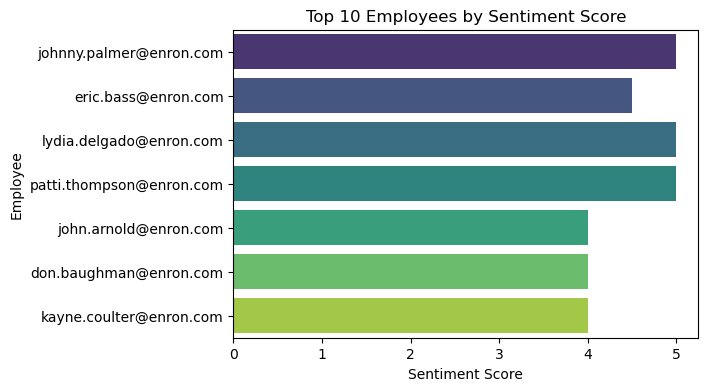

In [57]:
# Top 10 employees with highest sentiment score 
top_employees = monthly_scores.sort_values('sentiment_score', ascending=False).head(10)

# Plotting the top 10 employees
plt.figure(figsize=(6,4))
sns.barplot(x='sentiment_score', y='employee', data=top_employees, palette='viridis', errorbar = None)
plt.title('Top 10 Employees by Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Employee')
plt.show()

- Monthly sentiment scores are calculated by assigning +1 for Positive, -1 for Negative, and 0 for Neutral messages per employee.
- This approach effectively aggregates sentiment over time, enabling month-wise employee sentiment assessment.
- Scores reset monthly to reflect short-term sentiment changes.
- The scoring mechanism helps quantify engagement levels and sentiment per employee and month.
- Top 10 employees based on sentiment scores are identified.

#### Task 4: Employee Ranking
- Ranking employees monthly by sentiment score to identify top positive and negative contributors.

In [32]:
# Input the desired year and month for top 3 employees
year = input("Enter year (2010 or 2011): ").strip()
month = input("Enter month (01 for Jan, 02 for Feb ....): ").strip()
selected_period = f"{year}-{month}"

rankings = []

# Grouping monthly_scores by month and processing each group
for month, group in monthly_scores.groupby('month'):
    # Sorting employees by sentiment_score descending (positive ranking), then alphabetically by employee name
    top_positive = group.sort_values(['sentiment_score', 'employee'], ascending=[False, True]).head(3)
    
    # Sorting employees by sentiment_score ascending (negative ranking), then alphabetically by employee name
    top_negative = group.sort_values(['sentiment_score', 'employee'], ascending=[True, True]).head(3)
    rankings.append({'month': month, 'top_positive': top_positive, 'top_negative': top_negative})

monthly_ranking = next((r for r in rankings if str(r['month']) == selected_period), None)

# Displaying top 3 positive and negative employees for a selected month
if monthly_ranking is None:
    print(f"No ranking data found for {selected_period}")
else:
    print(f"\nEmployee Sentiment Rankings for {selected_period}\n")
    
    print("Top 3 Positive Employees:")
    print(monthly_ranking['top_positive'][['employee', 'sentiment_score']].to_string(index=False))
    
    print("\nTop 3 Negative Employees:")
    print(monthly_ranking['top_negative'][['employee', 'sentiment_score']].to_string(index=False))

Enter year (2010 or 2011):  2011
Enter month (01 for Jan, 02 for Feb ....):  02



Employee Sentiment Rankings for 2011-02

Top 3 Positive Employees:
                employee  sentiment_score
 lydia.delgado@enron.com                2
     eric.bass@enron.com                1
patti.thompson@enron.com                1

Top 3 Negative Employees:
                   employee  sentiment_score
    kayne.coulter@enron.com               -4
       sally.beck@enron.com               -4
bobette.riner@ipgdirect.com               -3


- Employees are ranked monthly by their aggregated sentiment scores.
- The top 3 most positive and top 3 most negative employees are identified for each month.
- Ranking is sorted first by descending sentiment score, then alphabetically by employee email for ties.
- This ranking provides actionable insights into individuals contributing positively or negatively to workplace sentiment.

#### Task 5: Flight Risk Identification

- Identifying employees who sent 4 or more negative messages within any rolling 30-day window.
- This identifies potentialissues in employee engagement and retention based on negative messagess.

In [35]:
# Filtering only negative messages with dates
neg_msgs = df[df['sentiment'] == 'Negative'].copy()
neg_msgs['date'] = pd.to_datetime(neg_msgs['date']) # Making sure 'date' is datetime type
neg_msgs = neg_msgs.sort_values(['from', 'date']) # Sorting for rolling count

# Adding helper column with 1s to count messages
neg_msgs['count'] = 1

# Defining rolling count function to count negative messages in last 30 days per employee
def rolling_neg_count(group):
    group = group.set_index('date') # Set date as index
    return group['count'].rolling('30D').sum() # Rolling 30-day sum on count column

# Calculating rolling negative message counts
rolling_counts = neg_msgs.groupby('from').apply(rolling_neg_count).reset_index() 
rolling_counts = rolling_counts.rename(columns={'count': 'rolling_30d_neg'})

# Merging rolling counts back into negative messages dataframe
neg_msgs = pd.merge(neg_msgs, rolling_counts, on=['from', 'date'], how='left')

# Identifying flight risk employees with rolling count >= 4
flight_risk_employees = neg_msgs[neg_msgs['rolling_30d_neg'] >= 4]['from'].unique()

print("Employees flagged as flight risk:")
for each in flight_risk_employees:
    print(each)

Employees flagged as flight risk:
bobette.riner@ipgdirect.com
don.baughman@enron.com
eric.bass@enron.com
john.arnold@enron.com
johnny.palmer@enron.com
kayne.coulter@enron.com
lydia.delgado@enron.com
patti.thompson@enron.com
rhonda.denton@enron.com
sally.beck@enron.com


- Flight risk is defined as employees sending 4 or more negative messages in any rolling 30-day window.
- This rolling window approach capturs short-term spikes in negativity irrespective of calendar months.
- Several employees are flagged as flight risks, highlighting possible disengagement or dissatisfaction.
- This method offers a proactive way to identify employees who may require attention or intervention.

#### Task 6: Predictive Modeling

- Using features like message frequency, message length, average message length, and word count.
- Training a linear regression model to predict monthly sentiment scores.
- Evaluating model performance using R² and RMSE.
- Interpreting feature importance via model coefficients.

In [39]:
# Aggregating monthly features per employee
monthly_features = df.groupby(['from', 'month']).agg(
    msg_count=('body', 'count'),                 # No. of messages per month per employee
    total_msg_length=('message_length', 'sum'),  # total characters sent in month
    avg_msg_length=('message_length', 'mean'),   # Average message length
    max_msg_length=('message_length', 'max'),    # Maximum message length
    min_msg_length=('message_length', 'min'),    # Minimum message length
    total_word_count=('body', lambda texts: sum(len(str(t).split()) for t in texts)),  # total words sent
    std_msg_length=('message_length', 'std'),    # Std deviation of message length
    pos_count=('sentiment', lambda x: (x == 'Positive').sum()), # Count of positive messages
    sentiment_score=('sentiment_score', 'sum') # Target variable: sum of sentiment scores
).reset_index()

monthly_features.rename(columns={'from':'employee'}, inplace=True)

# Filling any NaNs in std_msg_length (can happen if only one message) with 0
monthly_features['std_msg_length'] = monthly_features['std_msg_length'].fillna(0)

# Preparing independent variables and target variable
features = ['msg_count', 'total_msg_length', 'avg_msg_length', 
            'max_msg_length', 'min_msg_length', 
            'total_word_count', 'std_msg_length', 
            'pos_count']

X = monthly_features[features]
y = monthly_features['sentiment_score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Prediction and evaluating the metrics
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance on Test Set:")
print(f"R2 Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Coefficients interpretation
coefficients = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
coefficients

Model Performance on Test Set:
R2 Score: 0.955
RMSE: 0.577


,feature,coefficient
0,msg_count,-0.928075
1,total_msg_length,0.000487
2,avg_msg_length,0.000729
3,max_msg_length,-0.001439
4,min_msg_length,-0.000337
5,total_word_count,-0.002321
6,std_msg_length,0.001187
7,pos_count,1.947352


- Developed a linear regression model using features including message count, message length metrics, word count, and positive message count.
- The model achieved a strong performance (R2 ~ 0.955, RMSE ~ 0.577), indicating these features collectively explain most variation in sentiment scores.
- Positive message count showed the largest positive impact on sentiment, reinforcing its importance as an engagement indicator.
- Other features realted to message length (total, average, max, min, std) had smaller but notable effects.
- The model helps quantify how communication patterns influence sentiment trends and may support forecasting and HR decision-making.

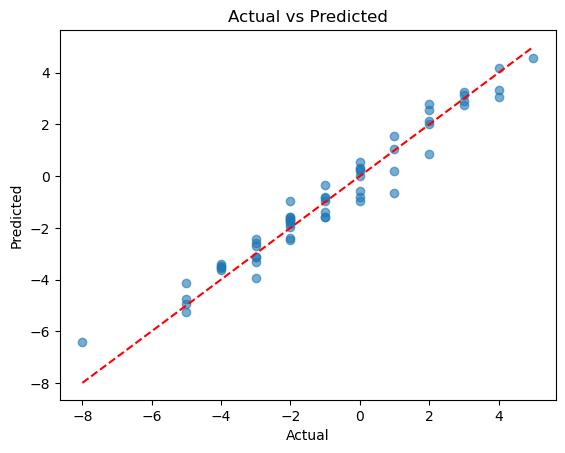

In [48]:
# Actual vs Predicted Scatter Plot
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

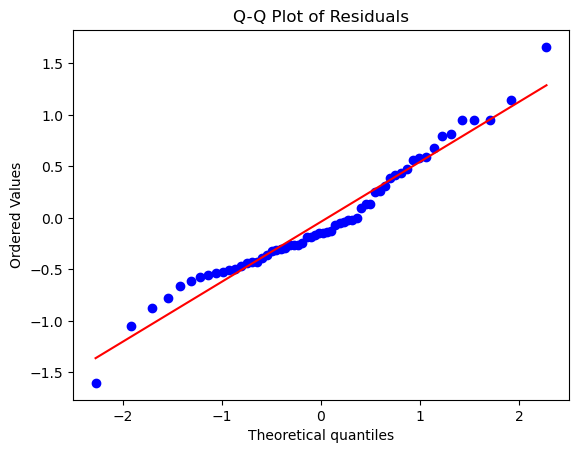

In [49]:
# Q-Q Plot (Quantile-Quantile Plot)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

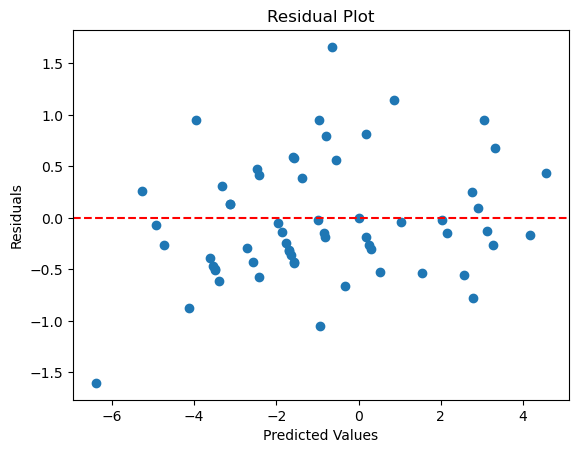

In [45]:
# Residual Plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


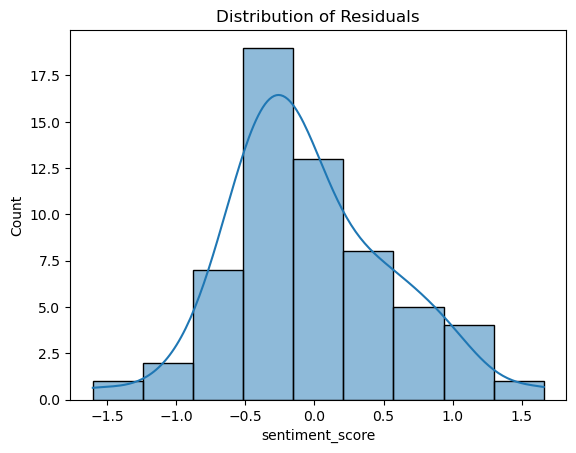

In [46]:
# Distribution of Residuals
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

- Actual vs Predicted Plot: Predictions closely align with actual sentiment scores, indicating good model accuracy.
- Q-Q Plot of Residuals: Residuals approximately follow a normal distribution, supporting model assumptions.
- Residual Plot: Residuals scatter randomly around zero, showing no bias.
- Distribution of Residuals: Residuals are symmetrically distributed around zero, indicating unbiased errors.